When performing exploration of environments we'd like to know how many times we've been in the current state.

In [93]:
import math
import matplotlib.pyplot as plt
import string
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(0)
torch.set_grad_enabled(False);

## Idea 0: count numbers

Assume all experience is finite and discrete.

In this example, given a buffer `x` of $T=7$ experience of kinds 0..10 exclusive, use `torch.unique` to count occurrences.

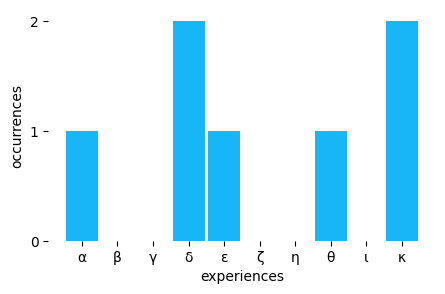

In [94]:
T = 7
experience = torch.randint(0, 10, (T,))
experience

unique_experience, counts = torch.unique(experience, return_counts=True)
histo = torch.zeros(10, dtype=torch.long).scatter_(0, unique_experience, counts)
plt.subplots(1, 1, figsize=(5,3))
plt.bar(torch.arange(10), histo, width=0.9, color='#18b6f4')
plt.xticks(range(10), 'αβγδεζηθικ')
plt.xlabel('experiences')
plt.yticks(range(0, max(counts)+1))
plt.ylabel('occurrences')
plt.box(False);

When our experience happens to be infinite and multidimensional, let's force it to be finite, discrete and one-dimensional. 


## Idea 1: quantize vectors

Define a fixed codebook with $V$ experience prototypes. Given a query experience match the closest prototype using inner product or p-norm, then count prototype identifiers.

Below I'm going to show an example of a randomly initialized codebook.

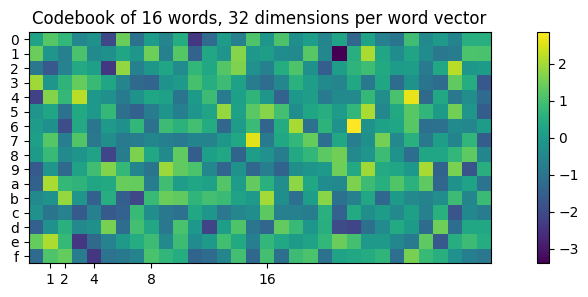

In [4]:
V, D = 16, 32
table = nn.Embedding(V, D) 
words = table.weight.detach().numpy()
plt.figure(figsize=(12,3))
plt.imshow(words, interpolation='nearest')
plt.yticks(range(len(words)), string.printable[:len(words)])
plt.xticks([2**i for i in range(5)])
plt.title('Codebook of 16 words, 32 dimensions per word vector')
plt.colorbar()

Now given a random experience $x$ I'm going to use a fast algorithm to compute pairwise L2 norms with the vocabulary. It's mentioned in [Kim, Papamakarios and Mnih, 2020](https://openreview.net/forum?id=DHSNrGhAY7W) and [this CSCS tutorial on HPC for Python](https://github.com/eth-cscs/PythonHPC/blob/master/numpy/03-euclidean-distance-matrix-numpy.ipynb).

In [5]:
x = torch.randn(T, D) # experience
y = table.weight.data # discrete prototypes

l2_norm_similarity_slow = torch.norm(x[:, None, :] - y[None, :, :], p=2, dim=-1) # (T, V)
l2_norm_similarity_fast = ((x*x).sum(dim=-1)[:,None] - 2*(x @ y.T) + (y*y).sum(dim=-1)[None, :]).abs().sqrt() # (T,V)
torch.allclose(l2_norm_similarity_slow, l2_norm_similarity_fast)

True

Now `argmin` gives us our hard assignment to codebook ids:

In [6]:
l2_norm_similarity_fast.argmin(dim=-1)

tensor([ 4, 10,  6,  7, 15,  8,  8])

"Good" prototype vectors can be estimated from data using algorithms like [LBG](https://github.com/r9y9/SPTK/blob/master/bin/lbg/_lbg.c), Lloyd's (aka k-means), CBOW in [Mikolov et al, 2013](https://arxiv.org/abs/1301.3781), next word prediction, etc.

However, sometimes random codebooks are enough.

In reinforcement learning, random projections of observations are used in a variant of artificial curiosity. An agent is rewarded proportional to the prediction error of a random projection of the state in [Burda et al, 2018](https://arxiv.org/abs/1810.12894).

Consistency objective of random targets is used to bootstrap self-supervised representations in [Tarvainen & Valpola, 2017](https://arxiv.org/abs/1703.01780). Random projection quantization is used for large scale self-supervised learning in speech recognition in [Chiu et al, 2022](https://proceedings.mlr.press/v162/chiu22a.html) to make learning targets.

Hard assignment, however, is not differentiable. To [backpropagate through hard assignment](https://www.youtube.com/watch?v=AIiwuClvH6k) you need to use algorithms like REINFORCE. Such estimation gives very noisy gradient estimates: in REINFORCE you only mark assignments that "worked" and ignore negative information.

## Idea 2: count softly

Matching can be done against noisy versions of vector observations.
Example below uses dot product attention to match and count.

Alternatively 2-norm can be used instead of the dot product. L2 attention has bounded gradient, as shown in [Kim, Papamakarios and Mnih, 2020](https://openreview.net/forum?id=DHSNrGhAY7W). This fact can be useful later.

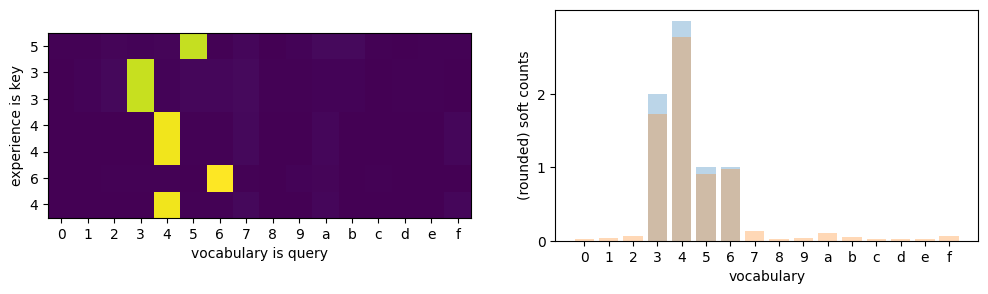

In [7]:
keys = table(experience) # keys is the experience sequence of length T
query = table(torch.arange(len(words))) # keys are the whole vocabulary V
att = (keys @ query.T) / math.sqrt(D) # (T, V)
att = att.softmax(dim=-1)
soft_counts = att.sum(dim=0)

fig, (axl,axr) = plt.subplots(1, 2, figsize=(12, 3))
axl.imshow(att)

axl.set_yticks(ticks=range(len(experience)), labels=experience.tolist());
axl.set_xticks(ticks=range(len(query)), labels=string.printable[:len(query)]);
axl.set_ylabel('experience is key')
axl.set_xlabel('vocabulary is query')
axr.bar(range(len(query)), soft_counts.round().tolist(), alpha=0.3)
axr.bar(range(len(query)), soft_counts.tolist(), alpha=0.3)
axr.set_xticks(ticks=range(len(query)), labels=string.printable[:len(query)]);
axr.set_yticks(ticks=range(3));
axr.set_ylabel('(rounded) soft counts')
axr.set_xlabel('vocabulary');

Attention requires us to store all experience in memory, and to compute the attention weights for all experience in memory. This is a quadratic cost in the number of experience. This is not scalable. We need to find a way to approximate the attention weights.

## Idea 3: running counts

We perform counting recurrently, updating a hidden state of word counts. This downgrades complexity of updates from quadratic to linear.

Once observations are discrete (e.g. turned discrete through elaborate quantization), this can be implemented with `cumsum`.

In [8]:
B, T, V = 2, 7, 4
observations = torch.randint(0, V, (B, T)).view(-1)
one_hot_observations = F.one_hot(observations).view(B,T,V)
running_counts = one_hot_observations.cumsum(dim=-2)
running_counts

tensor([[[0, 1, 0, 0],
         [0, 2, 0, 0],
         [0, 3, 0, 0],
         [1, 3, 0, 0],
         [1, 3, 1, 0],
         [1, 3, 2, 0],
         [2, 3, 2, 0]],

        [[0, 0, 1, 0],
         [0, 0, 1, 1],
         [0, 0, 1, 2],
         [1, 0, 1, 2],
         [1, 0, 1, 3],
         [2, 0, 1, 3],
         [2, 1, 1, 3]]])

## Idea 4: abstract over embedding tables

Different environments provide different possible "vocabularies" of experience. 
All vocabularies are sampled from $\mathcal{N}(0,I)$. Let's train a recurrent network to predict how many times it has seen a given input plus one.

In [9]:
# spot init.normal_
nn.Embedding.reset_parameters??

Signature: nn.Embedding.reset_parameters(self) -> None
Docstring: <no docstring>
Source:   
    def reset_parameters(self) -> None:
        init.normal_(self.weight)
        self._fill_padding_idx_with_zero()
File:      ~/curiosity/.venv/lib/python3.10/site-packages/torch/nn/modules/sparse.py
Type:      function

In [10]:
def make_batch():
    """
    Generate random observation sequences and a class index
    that tells if we've seen the observation once (class 0), twice (class 1) or many times (class 2) before.

    Returns:
    inputs (torch.Tensor): A tensor of shape (B, T, D) containing the embeddings
    of the observation sequences, where B is the batch size, T is the sequence length,
    and D is the embedding dimension.

    targets (torch.Tensor): A tensor of shape (B, T) containing the class index,
    where B is the batch size and T is the sequence length.
    """
    B, T, D, Vlocal = 32, 7, 32, 4
    Vglobal = B*Vlocal
    local_word_ids = torch.randint(0, 4, (B, T,))
    table = nn.Embedding(Vglobal, D)
    global_word_ids = torch.arange(B)[:, None]*4 + local_word_ids
    inputs = table(global_word_ids)
    current_input = F.one_hot(local_word_ids.view(-1), num_classes=Vlocal).view(B, T, Vlocal)
    counts = current_input.cumsum(dim=1)

    # how many times have we seen the current input so far? one, two or many
    targets = (counts * current_input).clamp(0, 3)
    targets = targets.sum(-1) - 1
    return inputs, targets

I'll be using [LSTM](https://people.idsia.ch/~juergen/lstm2003tutorial.pdf) that has an inductive bias towards counting thanks to its forget gates. This has been mentioned in [Deletang et al, 2023](https://iclr.cc/virtual/2023/oral/12616) putting LSTM in context with other architectures.

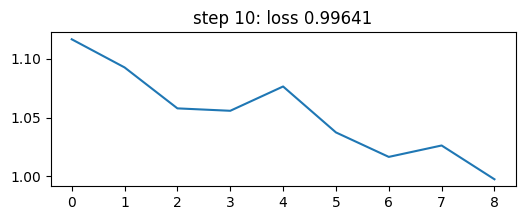

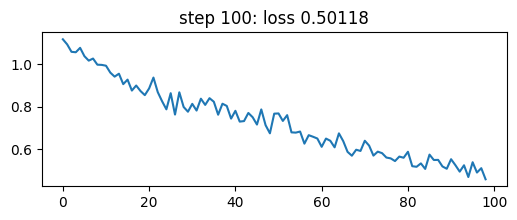

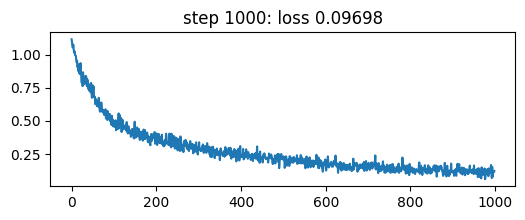

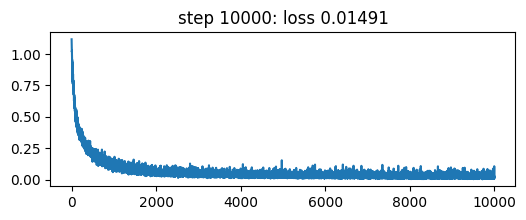

In [11]:
class Counter(nn.Module):
    def __init__(self, dim=32, hidden=512):
        super().__init__()
        self.readin = nn.Linear(dim, hidden)
        self.rnn = nn.LSTM(hidden, hidden, batch_first=True)
        self.readout = nn.Linear(hidden, 3) # one, two or many times

    def forward(self, x):
        x = self.readin(x)
        x, _ = self.rnn(x)
        x = self.readout(x)
        return x

torch.set_grad_enabled(True)
device = 'cuda:1'
counter = Counter().to(device)
optimizer = torch.optim.Adam(counter.parameters(), lr=1e-3)

N = 10000
losses = torch.zeros(N)

for step in range(1,N+1):
    inputs, targets = make_batch()
    inputs, targets = inputs.to(device), targets.to(device)
    logits = counter(inputs)
    loss = F.cross_entropy(logits.view(-1, 3), targets.view(-1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses[step-1] = loss.item()
    if step > 1 and math.log10(step) % 1 == 0:
        plt.figure(figsize=(6,2))
        plt.plot(losses[:step-1].numpy())
        plt.title(f'step {step}: loss {loss:.5f}')
        plt.show()

Now, let's test the counter.

In [12]:
inputs, targets = make_batch()
counter(inputs[0, :].to(device)).argmax(dim=-1), targets[0, :].to(device)

(tensor([0, 1, 0, 2, 1, 2, 0], device='cuda:1'),
 tensor([0, 1, 0, 2, 1, 2, 0], device='cuda:1'))

This almost gives us a generic counter of experience taken from a standard 32-dimensional normal distribution.

How to predict actual counts? One way is to perform regression to numeric targets.

In classification land we can take a softmax, however there is no inductive bias in the softmax towards relationships between output classes, which is why I took classes one, two and many to demonstrate the concept to begin with.

A way to add such bias is to use windowed label smoothing around the target (a trick from somewhere on kaggle, I'll need to find a link to it). Another way is to use mixture of logistics from [Salimans et al, 2017](https://arxiv.org/abs/1701.05517).